In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"
match_dist <- 10000
new_dataset <- "FVG"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    filter(sensor_key != 35L) |> # Muggia station has terrible data
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Veneto"), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(0L))
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "FVG", "raw_analysis.xlsx"))


In [21]:
source("notebooks/integrazioni_regionali/FVG/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


In [22]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
# Dealing with ISAC series
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    c("ARPAFVG", "SCIA", "ISAC"),
    desc(network_prio), desc(dataset), desc(sensor_last)
)
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 3L, 0.5, ignore_corrections)


In [23]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,dataset,sensor_key_x,name_y,network,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
86,0.5320320,0.66601606,-0.01562698,0.0406390641,43,52,355,1,0,Monte Zoncolan,ARPAFVG,57,Monte Zoncolan,Regionale ARPA FVG,1919
50,0.6230013,0.41835631,0.04900215,-0.0596347273,25,30,31,1,0,Monte Lussari sm,ARPAFVG,32,Monte Lussari (fino al 08/01/2018),ARPAFVG,33
58,0.8133971,0.00000000,0.00000000,0.0000000000,29,36,238,1,0,Pala d'Altei,ARPAFVG,39,PALA_D_ALTEI,DPC,3705
310,-0.6672709,-0.22294146,-0.01311752,0.0318874901,155,411,410,1,0,TOLMEZZO PONTE DI CANEVA,SCIA,3074,TOLMEZZO,Idrografica,3073
34,0.4597887,0.53528478,0.18053808,0.0333656280,25,30,352,1,0,Monte Lussari sm,ARPAFVG,32,Monte Lussari,Regionale ARPA FVG,1899
14,0.7899038,0.00000000,0.00000000,0.0000000000,11,15,218,1,0,Cividale del Friuli,ARPAFVG,16,CIVIDALE_S_M,DPC,3685
18,0.4307584,0.50714757,0.03317416,-0.0107775234,9,13,303,1,0,Cervignano del Friuli,ARPAFVG,14,Cervignano del Friuli,Regionale ARPA FVG,851
44,0.7490385,0.00000000,0.00000000,0.0000000000,35,43,249,1,0,Sgonico-Zgonik,ARPAFVG,47,SGONICO,DPC,3716
70,0.4150791,0.50888410,0.02868203,0.0549121556,35,43,406,1,0,Sgonico-Zgonik,ARPAFVG,47,Sgonico,Regionale ARPA FVG,3000


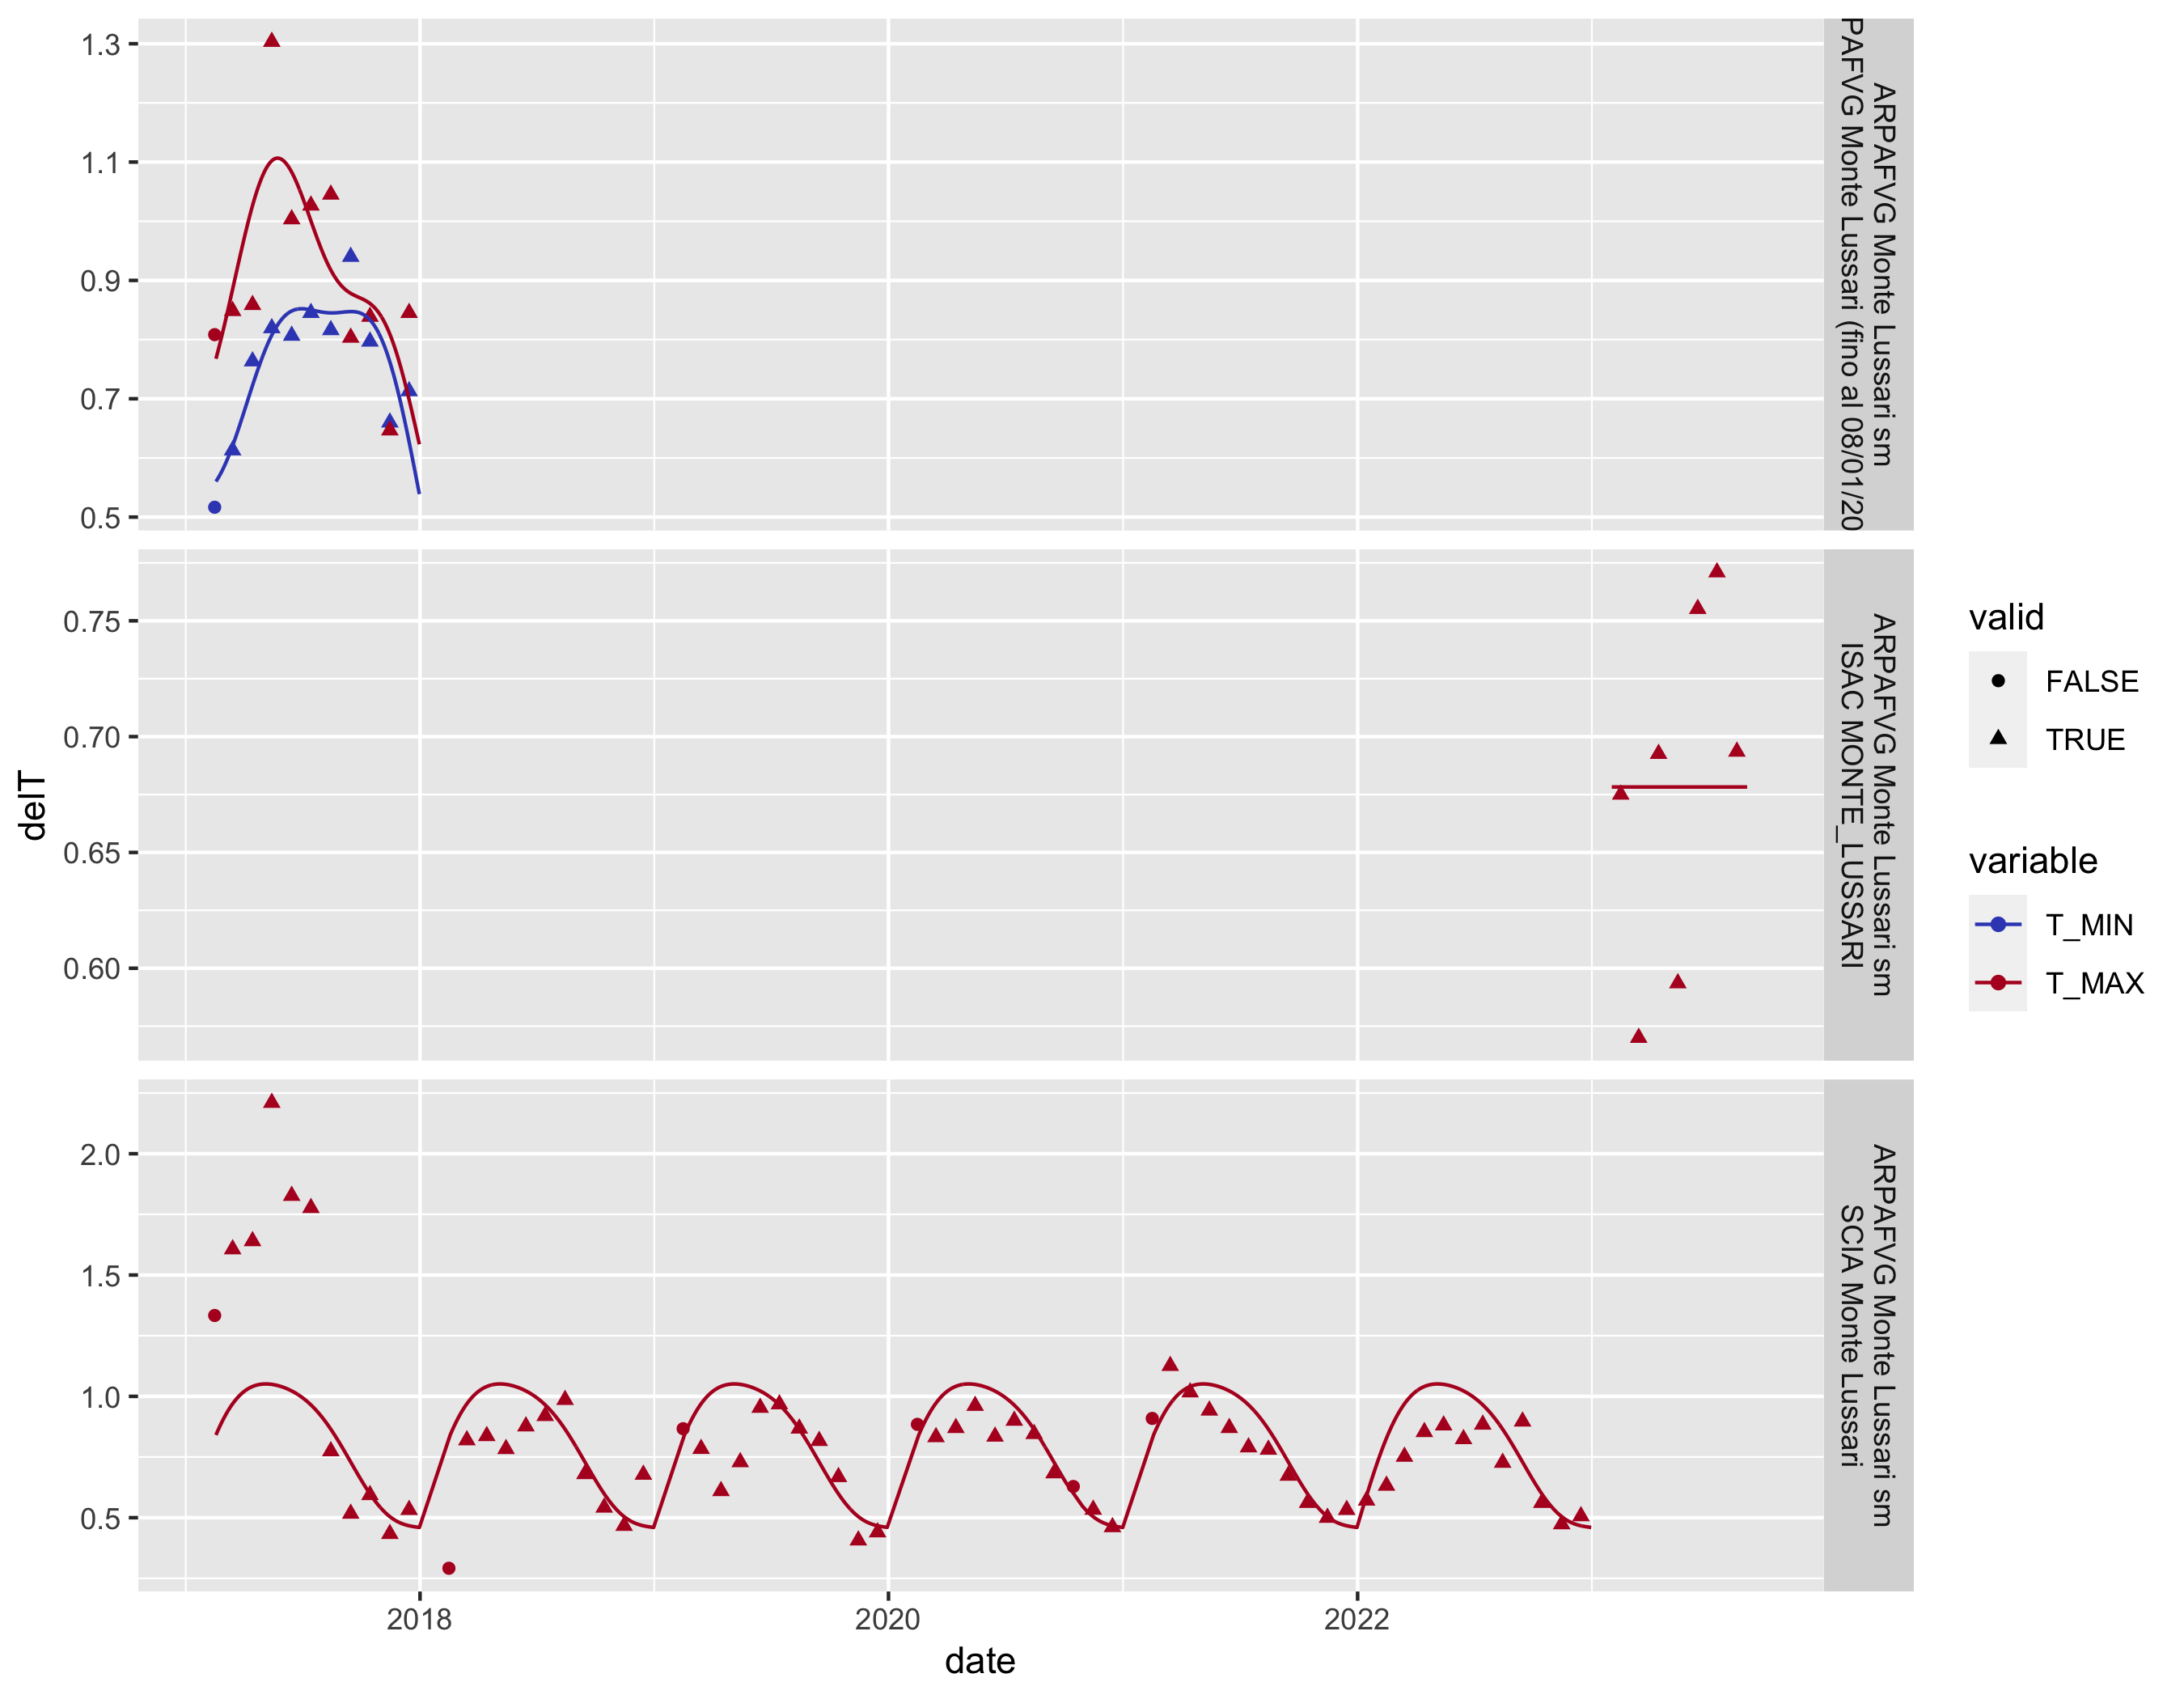

In [24]:
i |> filter(gkey == 25L) |> plot_correction(metadata, data)

In [25]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 10, ignore_corrections, contribution_threshold = 2L*365L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations)
# rm(merge_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2286643,122.2,3754112,200.5,NA,3754112,200.5
Vcells,29870736,227.9,104515388,797.4,16384,108782489,830.0


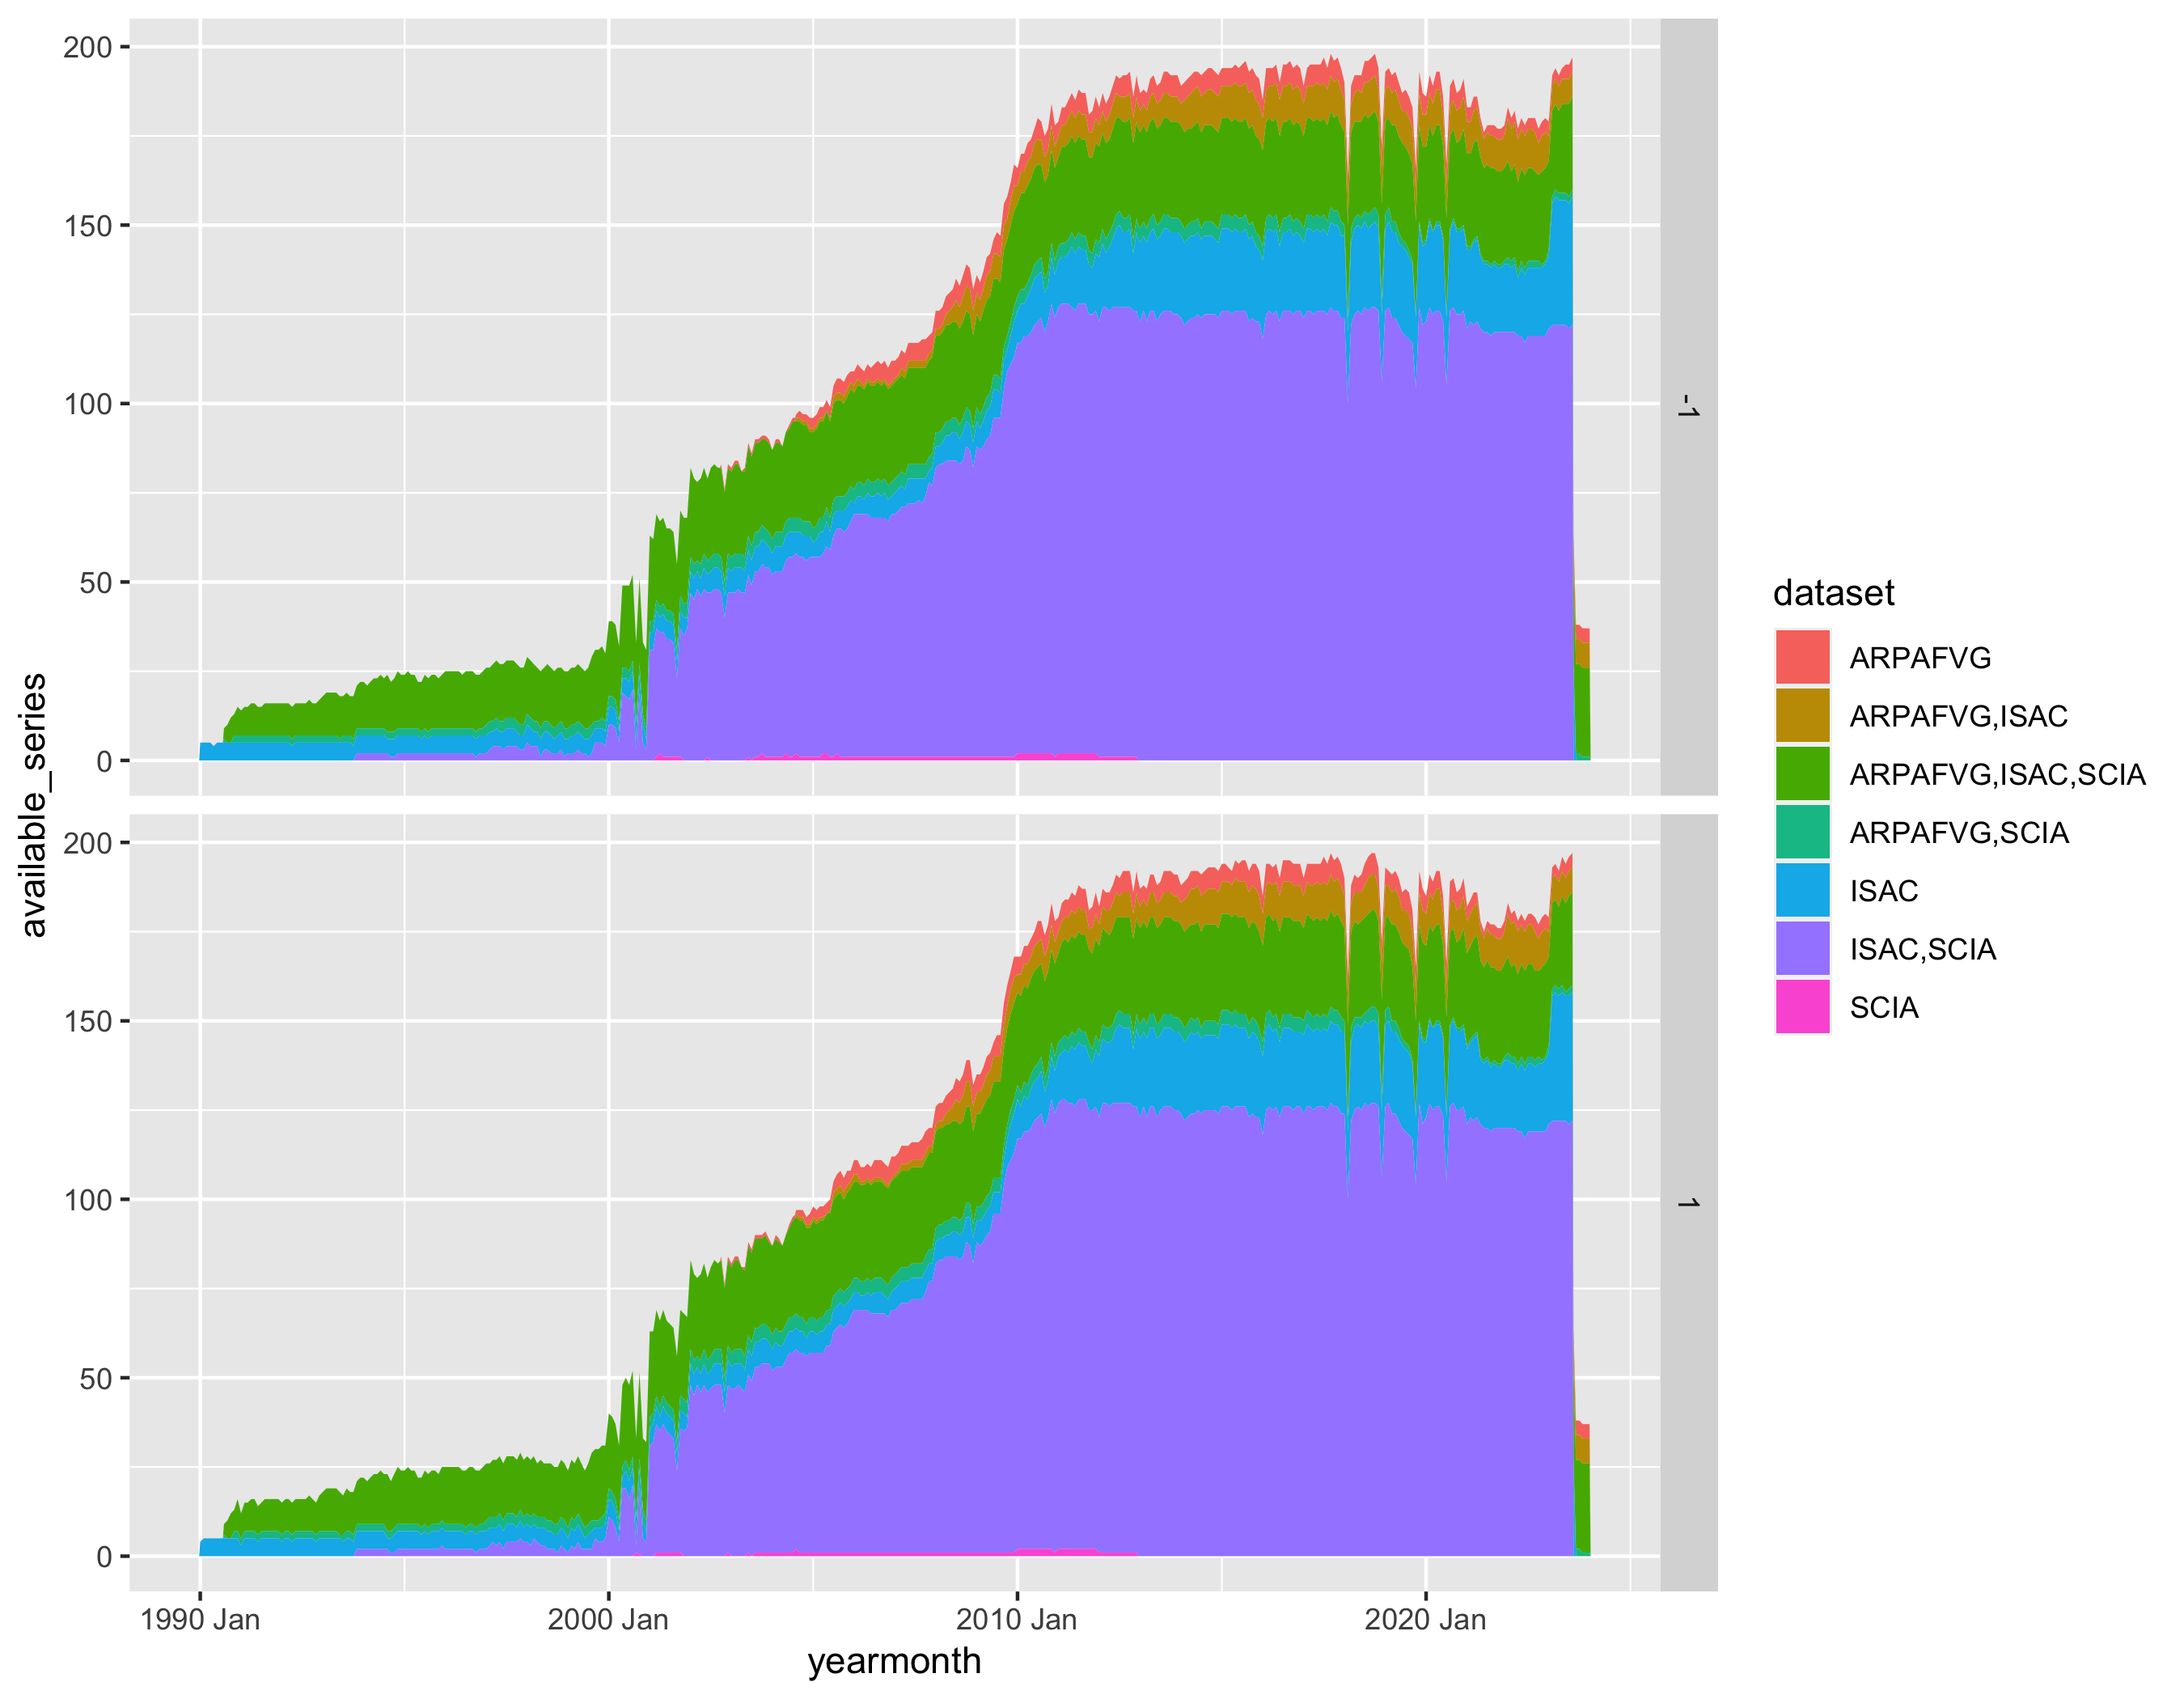

In [26]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |> select(sensor_key, from_datasets) |> collect() |> rowwise() |> mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |> ungroup() |> select(-from_datasets)
dt <- db$data |> select(-dataset) |> left_join(mt, by = "sensor_key", copy = TRUE) |> filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)

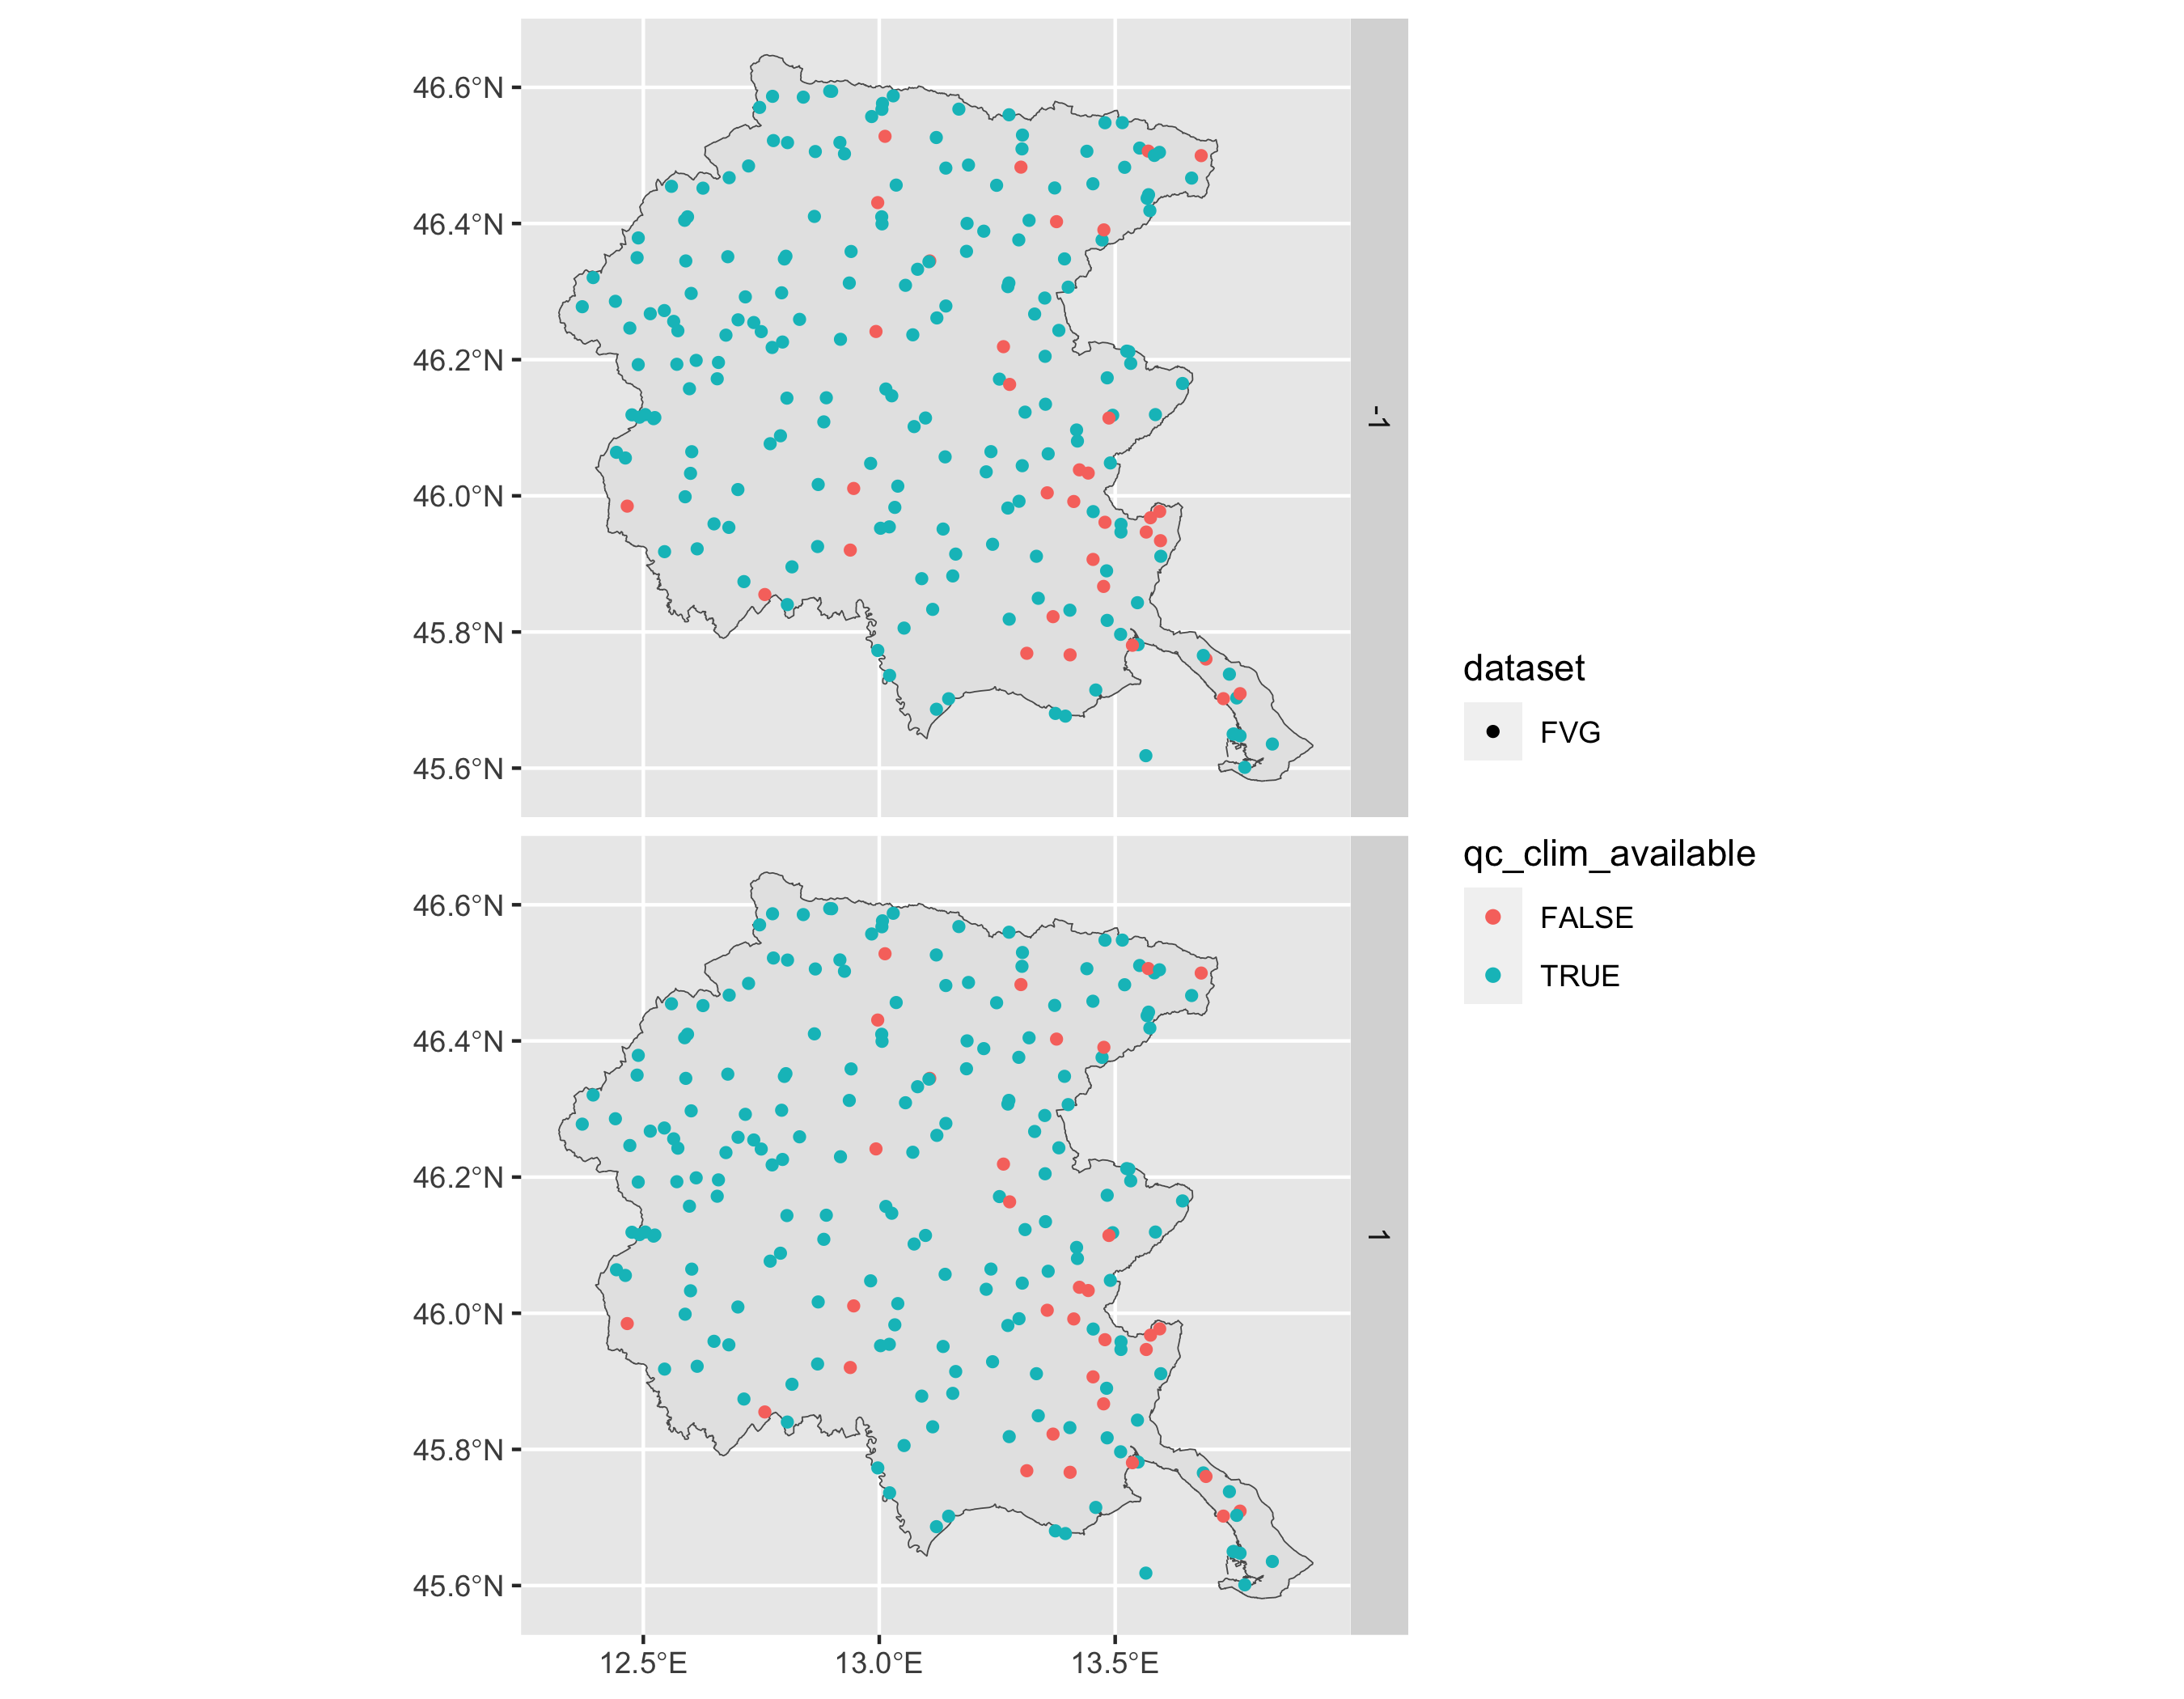

In [27]:
sp_data <- pd[[2]] |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries)
pd$plot + facet_grid(variable ~ .)